In [1]:
## First idea is to have 2 decoders
## One will be used for background generation, the other will be used for moving object generation

In [1]:

%pylab inline
import os
import cv2
import time
import numpy as np
import pandas as pd

import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image


os.getcwd()
home_dir = os.path.abspath('../../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac',  'DETRAC-Images')
data_dir

home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X, length_per_mvi = load.load_images(image_dir, grayscale = False)
Y_dict = load.load_XML(anno_dir, X, length_per_mvi)

print("Total time to load small data is", time.time() - start_time, "seconds")

  0%|          | 6/10427 [00:00<03:08, 55.21it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10427


100%|██████████| 10427/10427 [01:15<00:00, 137.26it/s]
1it [00:00,  2.60it/s]

MVI_20011.xml
mvi length: 665
car_labels length: 665


2it [00:00,  2.53it/s]

MVI_20012.xml
mvi length: 1602
car_labels length: 1602
MVI_20032.xml
mvi length: 2040
car_labels length: 2040


4it [00:01,  3.14it/s]

MVI_20033.xml
mvi length: 2825
car_labels length: 2825


5it [00:01,  2.78it/s]

MVI_20034.xml
mvi length: 3625
car_labels length: 3625


6it [00:01,  2.65it/s]

MVI_20035.xml
mvi length: 4425
car_labels length: 4425


7it [00:02,  2.47it/s]

MVI_20051.xml
mvi length: 5332
car_labels length: 5332


8it [00:02,  2.53it/s]

MVI_20052.xml
mvi length: 6026
car_labels length: 6026


9it [00:03,  2.58it/s]

MVI_20061.xml
mvi length: 6826
car_labels length: 6826


10it [00:03,  2.96it/s]

MVI_20062.xml
mvi length: 7626
car_labels length: 7626


11it [00:03,  3.08it/s]

MVI_20063.xml
mvi length: 8426
car_labels length: 8426


12it [00:04,  2.35it/s]

MVI_20064.xml
mvi length: 9226
car_labels length: 9226


13it [00:05,  1.88it/s]

MVI_20065.xml
mvi length: 10427
car_labels length: 10427
Total time to load small data is 81.19604802131653 seconds


In [3]:

def _split_train_test(X,Y_dict):
    n_samples, _, _, _= X.shape
    train_index_end = int(len(X) * 0.8)

    X_train = X[:train_index_end]
    X_test = X[train_index_end:]

    Y_dict_train = {}
    Y_dict_test = {}
    for column in Y_dict:
        Y_dict_train[column] = Y_dict[column][:train_index_end]
        Y_dict_test[column] = Y_dict[column][train_index_end:]

    return X_train, X_test, Y_dict_train, Y_dict_test

X_train, X_test, Y_train_dict, Y_test_dict = _split_train_test(X, Y_dict)



In [4]:
import sys
print(sys.executable)

/nethome/jbang36/anaconda3/envs/eva_37/bin/python


In [5]:

X_train_norm = np.copy(X_train)
X_test_norm = np.copy(X_test)

def _format_image_fixed(X, height, width):
    n_samples,_,_,channels = X.shape
    X_new = np.ndarray(shape=(n_samples, height, width, channels))
    for i in range(n_samples):
        X_new[i] = cv2.resize(X[i],  (width,height))
    
    X_new /= 255.0
        
    return X_new


def _format_image(X, sampling_rate=12):
    print("before:", X.shape)
    reduction_rate = sampling_rate
    # need to down shape them so that the kernels can train faster
    # image should be num_samples, height, width, channel
    downsampled_images = X[:, ::reduction_rate, ::reduction_rate, :]
    downsampled_images = downsampled_images.astype(np.float32)
    print("After change, shape of image is", downsampled_images.shape)
    downsampled_images /= 255.0
    return downsampled_images

X_train_norm = _format_image_fixed(X_train_norm, 40, 80)
X_test_norm = _format_image_fixed(X_test_norm, 40, 80)

X_train_norm = X_train_norm[1:] #we need to skip the first image because it is black....

40 80 3


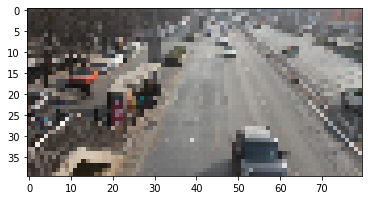

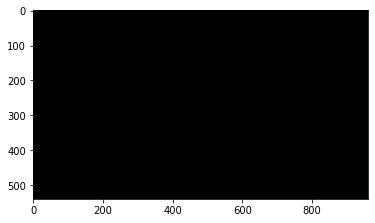

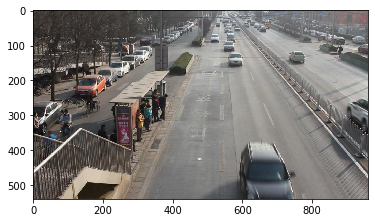

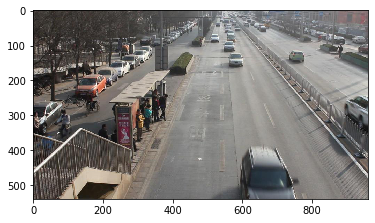

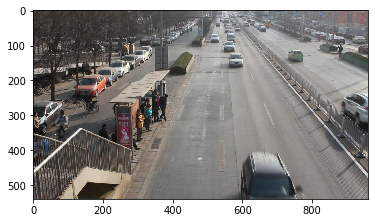

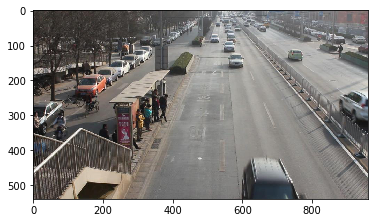

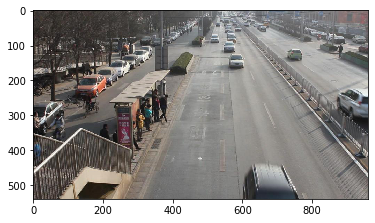

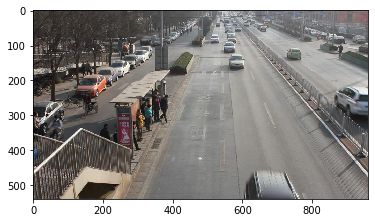

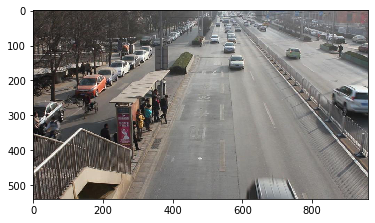

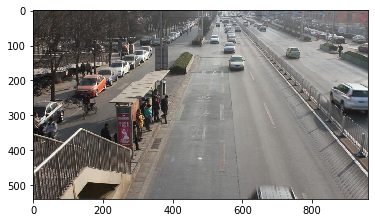

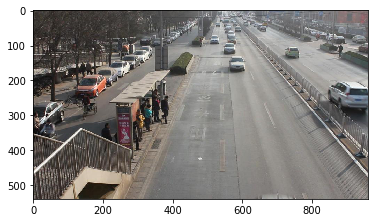

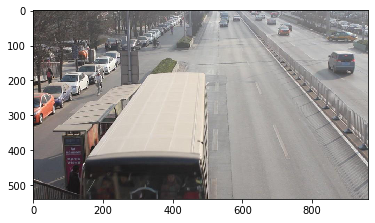

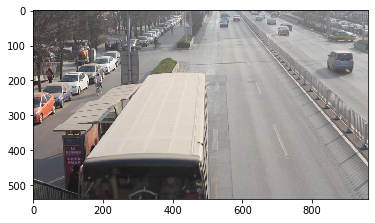

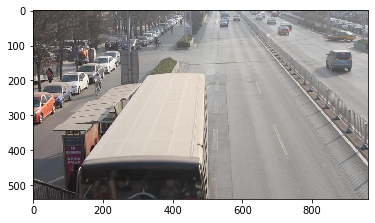

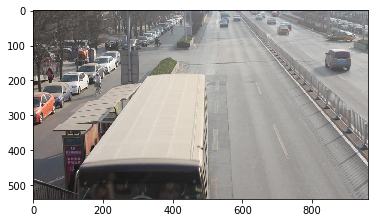

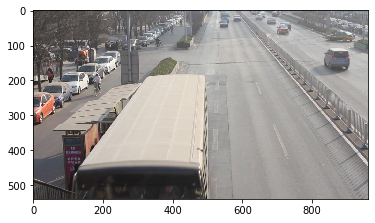

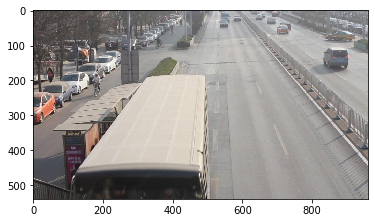

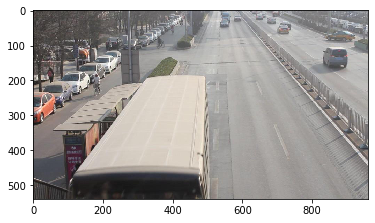

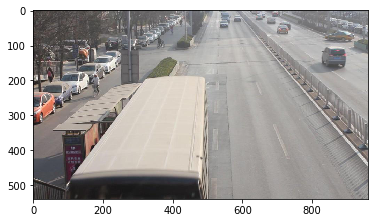

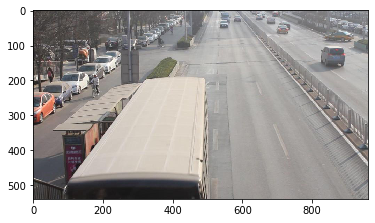

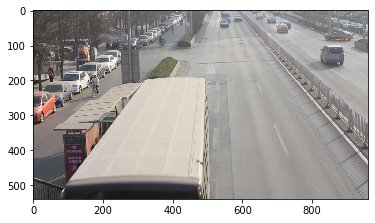

In [6]:

example = X_train_norm[0]
width, height, channels = example.shape
print(width, height, channels)
example = example * 255.0
example = example.astype(np.uint8)



plt.imshow(example)
plt.show()

for i in range(10):
    plt.imshow(X_train[i])
    plt.show()

for i in range(10):
    plt.imshow(X_test[i])
    plt.show()

In [7]:
import gc
gc.collect()


torch.cuda.empty_cache() 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.device(0)

In [8]:

# Writing our model
class Auto2decoder(nn.Module):
    def __init__(self):
        super(Auto2decoder,self).__init__()
        
        self.K = 10
        self.output_channels = 3
        self.input_channels = 6
        self.seg_channels = 5
        self.middle_neural_count = 100
        self.division = 0.5
        
        self.create_enc()
        input_shape = (64, 10, 20) #input (3,40,80)
        self.create_central(input_shape)
        self.create_decoder_b()
        self.create_decoder_d()
        self.create_final_conv_layer()
        
    def forward(self,x):
        x1 = self.u_enc1(x)
        x2 = self.u_enc2(x1)
        x3 = self.u_enc3(x2)
        #print(x1.shape)
        n,c,h,w = x3.shape
        compressed = self.central_layers1(x3.view(n, c*h*w))
        extended = self.central_layers2(compressed)
        #print("extended shape:", extended.size())
        background, foreground = extended[:, :int(self.division*extended.shape[1])], extended[:, int(self.division*extended.shape[1]):]
        #print("background shape: ", background.size())
        #print("foreground shape: ", foreground.size())
        background_ext = self.central_layers3(background)
        foreground_ext = self.central_layers4(foreground)
        xb1 = self.u_decb1(torch.cat( (x3, background_ext.view(n,c,h,w)), dim = 1))
        xb2 = self.u_decb2(torch.cat( (x2, xb1), dim = 1))
        background_regen = self.u_decb3(torch.cat( (x1, xb2), dim = 1))
        
        
        xd1 = self.u_decd1(torch.cat( (x3,foreground_ext.view(n,c,h,w)), dim = 1))
        xd2 = self.u_decd2(torch.cat( (x2, xd1), dim = 1))
        foreground_regen = self.u_decd3(torch.cat( (x1,xd2), dim = 1))
        #print(background_regen.size())
        #print(foreground_regen.size())
        final_regen = torch.cat((background_regen, foreground_regen), dim = 1)
        #print(final_regen.size())
        final_regen = self.final(final_regen)
        
        #final_regen = foreground_regen + background_regen
        return [compressed, background_regen, foreground_regen, final_regen]
        #return [compressed, background_regen, foreground_regen]
    
    def create_enc(self):
        self.u_enc1 = nn.Sequential()
        self.u_enc1.add_module('Conv1_1', nn.Conv2d(self.input_channels, 16, kernel_size=3, padding = (1,1)))
        self.u_enc1.add_module('Relu1_2', nn.ReLU(True))
        self.u_enc1.add_module('Conv1_3', nn.Conv2d(16,16,kernel_size=3, padding = (1,1)))
        self.u_enc1.add_module('Relu1_4', nn.ReLU(True))
        
        self.u_enc2 = nn.Sequential()
        self.u_enc2.add_module('Max2_0', nn.MaxPool2d(2, stride = 2))
        self.u_enc2.add_module('Conv2_1', nn.Conv2d(16, 32, kernel_size=3, padding = (1,1)))
        self.u_enc2.add_module('Relu2_2', nn.ReLU(True))
        self.u_enc2.add_module('Conv2_3', nn.Conv2d(32, 32, kernel_size=3, padding = (1,1)))
        self.u_enc2.add_module('Relu2_4', nn.ReLU(True))
        
        
        self.u_enc3 = nn.Sequential()
        self.u_enc3.add_module('Max3_0', nn.MaxPool2d(2, stride = 2))
        self.u_enc3.add_module('Conv3_1', nn.Conv2d(32, 64, kernel_size=3, padding = (1,1)))
        self.u_enc3.add_module('Relu3_2', nn.ReLU(True))
        self.u_enc3.add_module('Conv3_3', nn.Conv2d(64, 64, kernel_size=3, padding = (1,1)))
        self.u_enc3.add_module('Relu3_4', nn.ReLU(True))
        #self.u_enc3.add_module('Max3_5', nn.MaxPool2d(2, stride = 2))
        
    def create_central(self, input_shape):
        c,h,w = input_shape
        self.central_layers1 = nn.Sequential()
        self.central_layers1.add_module('Mlp', nn.Linear(c*h*w, self.middle_neural_count))
        
        self.central_layers2 = nn.Sequential()
        self.central_layers2.add_module('Mlp', nn.Linear(self.middle_neural_count, c*h*w))
        
        self.central_layers3 = nn.Sequential()
        self.central_layers3.add_module('Mlp', nn.Linear(int(c*h*w * self.division), c*h*w))
        
        self.central_layers4 = nn.Sequential()
        self.central_layers4.add_module('Mlp', nn.Linear(int(c*h*w * (1-self.division)), c*h*w))
        
    def create_decoder_b(self):
        self.u_decb1 = nn.Sequential()
        #self.u_decb1.add_module('CT4_1', nn.ConvTranspose2d(64, 64, kernel_size = 2, stride = 2))
        self.u_decb1.add_module('Conv4_2', nn.Conv2d(128, 64, kernel_size=3, padding = (1,1)))
        self.u_decb1.add_module('Relu4_3', nn.ReLU(True))
        self.u_decb1.add_module('Conv4_4', nn.Conv2d(64, 32, kernel_size=3, padding = (1,1)))
        self.u_decb1.add_module('Relu4_5', nn.ReLU(True))
        self.u_decb1.add_module('CT4_6', nn.ConvTranspose2d(32, 32, kernel_size = 2, stride = 2))
        
        
        self.u_decb2 = nn.Sequential()
        self.u_decb2.add_module('Conv5_2', nn.Conv2d(64, 32, kernel_size=3, padding = (1,1)))
        self.u_decb2.add_module('Relu5_3', nn.ReLU(True))
        self.u_decb2.add_module('Conv5_4', nn.Conv2d(32, 16, kernel_size=3, padding = (1,1)))
        self.u_decb2.add_module('Relu5_5', nn.ReLU(True))
        self.u_decb2.add_module('CT5_6', nn.ConvTranspose2d(16, 16, kernel_size = 2, stride = 2))
        
        
        self.u_decb3 = nn.Sequential()
        self.u_decb3.add_module('Conv6_2', nn.Conv2d(32, 8, kernel_size=3, padding = (1,1)))
        self.u_decb3.add_module('Relu6_3', nn.ReLU(True))
        self.u_decb3.add_module('Conv6_4', nn.Conv2d(8, self.output_channels, kernel_size=3, padding = (1,1)))
        self.u_decb3.add_module('Relu6_5', nn.ReLU(True))
        
    def create_decoder_d(self):
        self.u_decd1 = nn.Sequential()
        #self.u_decd1.add_module('CT4_1', nn.ConvTranspose2d(64, 64, kernel_size = 2, stride = 2))
        self.u_decd1.add_module('Conv4_2', nn.Conv2d(128, 64, kernel_size=3, padding = (1,1)))
        self.u_decd1.add_module('Relu4_3', nn.ReLU(True))
        self.u_decd1.add_module('Conv4_4', nn.Conv2d(64, 32, kernel_size=3, padding = (1,1)))
        self.u_decd1.add_module('Relu4_5', nn.ReLU(True))
        self.u_decd1.add_module('CT4_6', nn.ConvTranspose2d(32, 32, kernel_size = 2, stride = 2))
        
        
        self.u_decd2 = nn.Sequential()
        self.u_decd2.add_module('Conv5_2', nn.Conv2d(64, 32, kernel_size=3, padding = (1,1)))
        self.u_decd2.add_module('Relu5_3', nn.ReLU(True))
        self.u_decd2.add_module('Conv5_4', nn.Conv2d(32, 16, kernel_size=3, padding = (1,1)))
        self.u_decd2.add_module('Relu5_5', nn.ReLU(True))
        self.u_decd2.add_module('CT5_6', nn.ConvTranspose2d(16, 16, kernel_size = 2, stride = 2))
        
        
        self.u_decd3 = nn.Sequential()
        self.u_decd3.add_module('Conv6_2', nn.Conv2d(32, 8, kernel_size=3, padding = (1,1)))
        self.u_decd3.add_module('Relu6_3', nn.ReLU(True))
        self.u_decd3.add_module('Conv6_4', nn.Conv2d(8, self.seg_channels, kernel_size=3, padding = (1,1)))
        self.u_decd3.add_module('Soft6_5', nn.Softmax(dim = 1))
        
    def create_final_conv_layer(self):
        self.final = nn.Sequential()
        self.final.add_module('Conv7_1', nn.Conv2d(self.output_channels+self.seg_channels,self.output_channels,kernel_size = 1 ))
        self.final.add_module('Relu7_2', nn.ReLU(True))

In [9]:
def custom_distance_loss(y_hat, target, loss_amp_factor):
    return loss_amp_factor * ((y_hat - target)**2).mean()

In [10]:
model = Auto2decoder().cuda()
distance = nn.MSELoss()

# Loss Function Revision

batch_size = 64
n_samples, H, W, C = X_train_norm.shape

train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=batch_size, num_workers=4, drop_last=True)

#dist_diff_matrix = calculate_dist_matrix(batch_size, H,W)

In [ ]:
print("hello world")

## Explore the best background generation method (we just need a good delta image....)

In [ ]:
# shuffle is turned off, we will explore the idea t-6, t-3, t, t+3, t+6


for i, images in enumerate(train_loader):
    background_imgs = torch.mean(images, dim = 0)
    background_imgs = background_imgs.permute(1,2,0)
    background_imgs *= 255.0
    background_imgs = background_imgs.numpy()
    background_imgs = background_imgs.astype(np.uint8)
    plt.imshow(background_imgs)
    plt.show()
    if i == 5:
        break

In [11]:
def convert(recon):
    recon_p = recon.permute(0,2,3,1)
    #print(recon_p.size())
    recon_imgs = recon_p.detach().cpu().numpy()
    recon_imgs *= 255
    recon_imgs = recon_imgs.astype(np.uint8)
    return recon_imgs

def convert_soft(seged):
    K = 5


    N,K,H,W = seged.size()
    arged = torch.argmax(seged, dim = 1) #channels is 1
    arged = arged * 255 / (K - 1)
    arged_imgs = arged.detach().cpu().numpy()


    arged_imgs = arged_imgs.astype(np.uint8)
    assert(arged_imgs.shape == (N,H,W))
    return arged_imgs

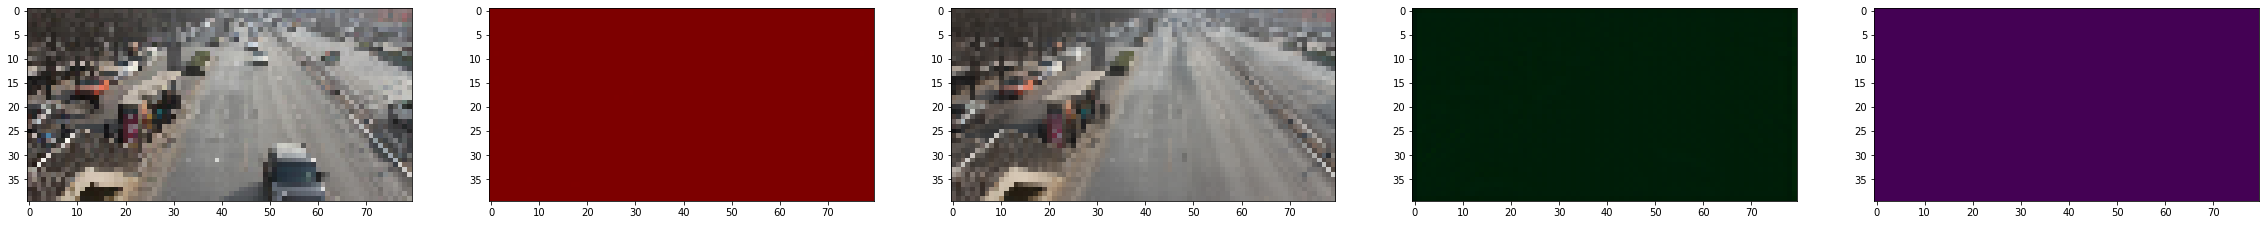

epoch [1/300], loss_total:0.2143, loss_background:0.0094, loss_all:0.2050, time elapsed:22.3679 (sec)
epoch [2/300], loss_total:0.2012, loss_background:0.0045, loss_all:0.1967, time elapsed:19.1507 (sec)
epoch [3/300], loss_total:0.1537, loss_background:0.0065, loss_all:0.1473, time elapsed:19.4199 (sec)
epoch [4/300], loss_total:0.1176, loss_background:0.0081, loss_all:0.1095, time elapsed:19.4533 (sec)
epoch [5/300], loss_total:0.0641, loss_background:0.0067, loss_all:0.0573, time elapsed:19.2045 (sec)


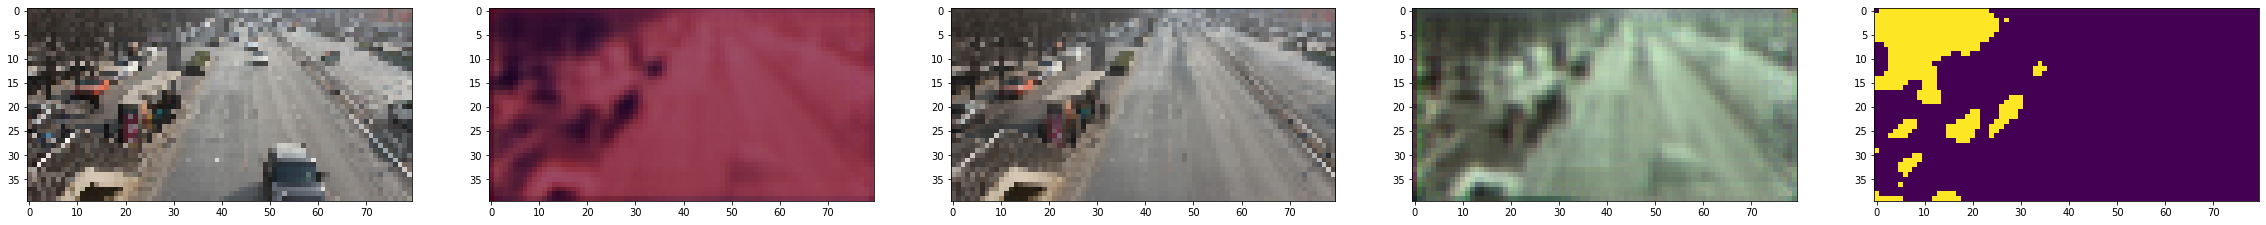

epoch [6/300], loss_total:0.0428, loss_background:0.0056, loss_all:0.0373, time elapsed:22.6091 (sec)
epoch [7/300], loss_total:0.0304, loss_background:0.0045, loss_all:0.0259, time elapsed:19.5649 (sec)
epoch [8/300], loss_total:0.0225, loss_background:0.0039, loss_all:0.0186, time elapsed:19.3439 (sec)
epoch [9/300], loss_total:0.0174, loss_background:0.0032, loss_all:0.0142, time elapsed:19.2280 (sec)
epoch [10/300], loss_total:0.0139, loss_background:0.0028, loss_all:0.0111, time elapsed:19.0815 (sec)


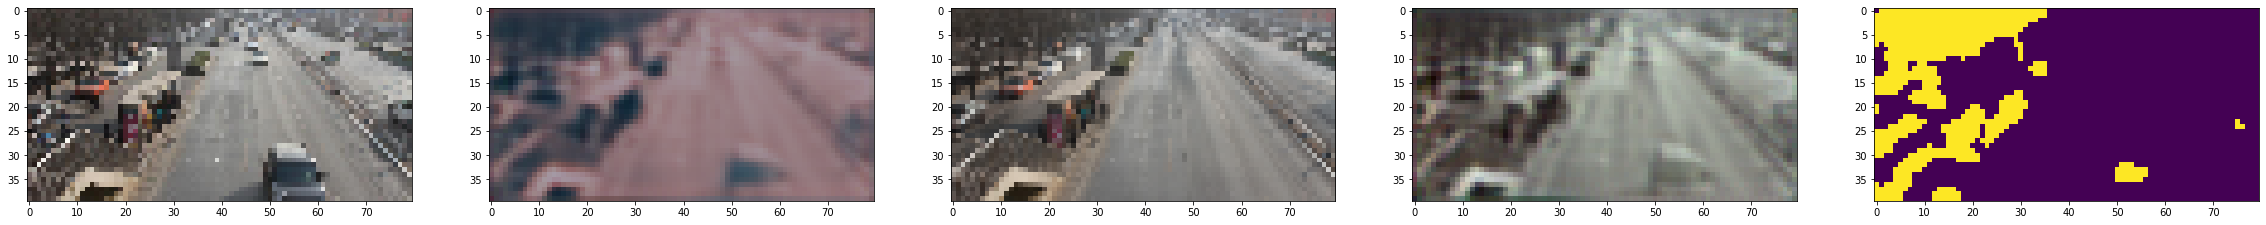

epoch [11/300], loss_total:0.0116, loss_background:0.0025, loss_all:0.0091, time elapsed:22.0091 (sec)
epoch [12/300], loss_total:0.0098, loss_background:0.0022, loss_all:0.0076, time elapsed:19.1762 (sec)
epoch [13/300], loss_total:0.0085, loss_background:0.0021, loss_all:0.0064, time elapsed:19.1608 (sec)
epoch [14/300], loss_total:0.0075, loss_background:0.0020, loss_all:0.0056, time elapsed:19.3442 (sec)
epoch [15/300], loss_total:0.0067, loss_background:0.0018, loss_all:0.0049, time elapsed:19.1891 (sec)


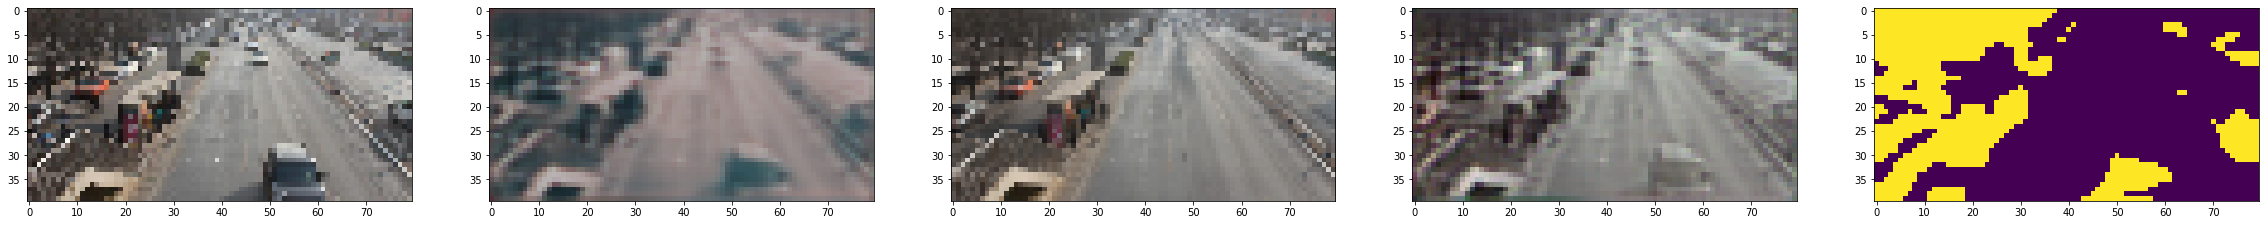

epoch [16/300], loss_total:0.0060, loss_background:0.0017, loss_all:0.0043, time elapsed:22.0187 (sec)
epoch [17/300], loss_total:0.0054, loss_background:0.0016, loss_all:0.0039, time elapsed:19.0495 (sec)
epoch [18/300], loss_total:0.0050, loss_background:0.0015, loss_all:0.0035, time elapsed:19.2252 (sec)
epoch [19/300], loss_total:0.0047, loss_background:0.0014, loss_all:0.0033, time elapsed:19.1500 (sec)
epoch [20/300], loss_total:0.0044, loss_background:0.0013, loss_all:0.0031, time elapsed:19.1281 (sec)


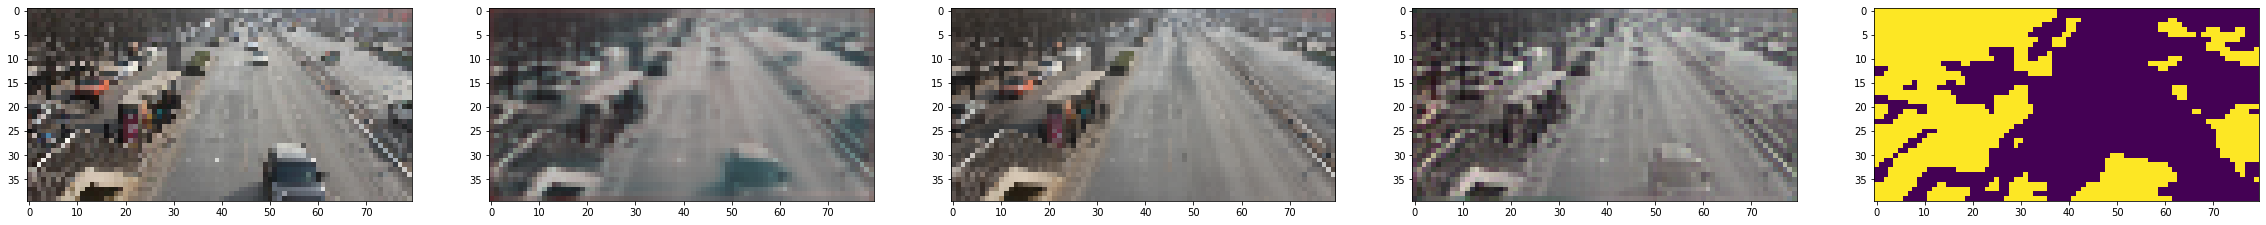

epoch [21/300], loss_total:0.0043, loss_background:0.0013, loss_all:0.0030, time elapsed:21.3967 (sec)
epoch [22/300], loss_total:0.0040, loss_background:0.0012, loss_all:0.0028, time elapsed:19.1094 (sec)
epoch [23/300], loss_total:0.0039, loss_background:0.0012, loss_all:0.0027, time elapsed:19.1432 (sec)
epoch [24/300], loss_total:0.0037, loss_background:0.0012, loss_all:0.0025, time elapsed:19.2898 (sec)
epoch [25/300], loss_total:0.0036, loss_background:0.0011, loss_all:0.0025, time elapsed:19.0999 (sec)


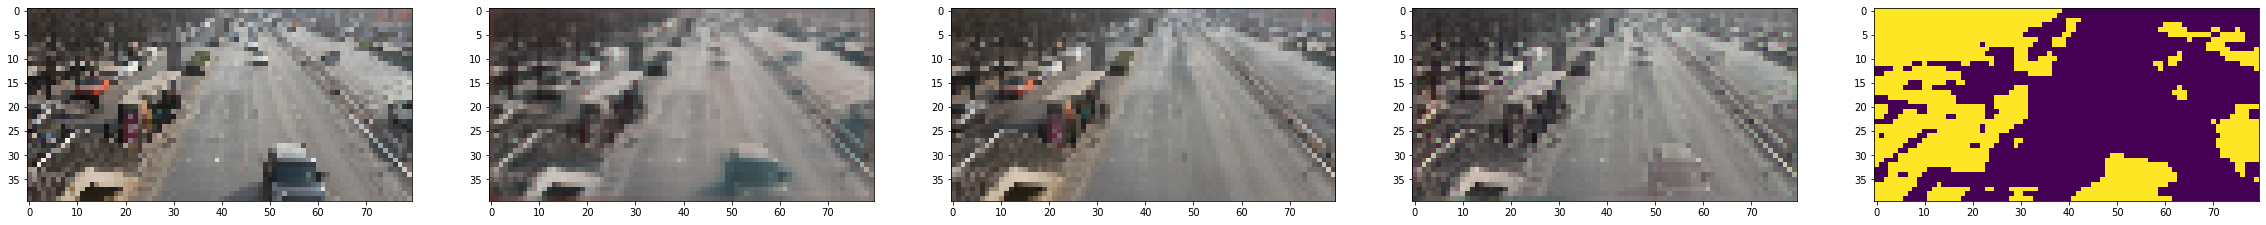

epoch [26/300], loss_total:0.0034, loss_background:0.0011, loss_all:0.0023, time elapsed:22.4059 (sec)
epoch [27/300], loss_total:0.0032, loss_background:0.0010, loss_all:0.0022, time elapsed:19.6185 (sec)
epoch [28/300], loss_total:0.0033, loss_background:0.0010, loss_all:0.0023, time elapsed:19.2448 (sec)
epoch [29/300], loss_total:0.0031, loss_background:0.0010, loss_all:0.0021, time elapsed:19.0264 (sec)
epoch [30/300], loss_total:0.0029, loss_background:0.0010, loss_all:0.0019, time elapsed:19.2810 (sec)


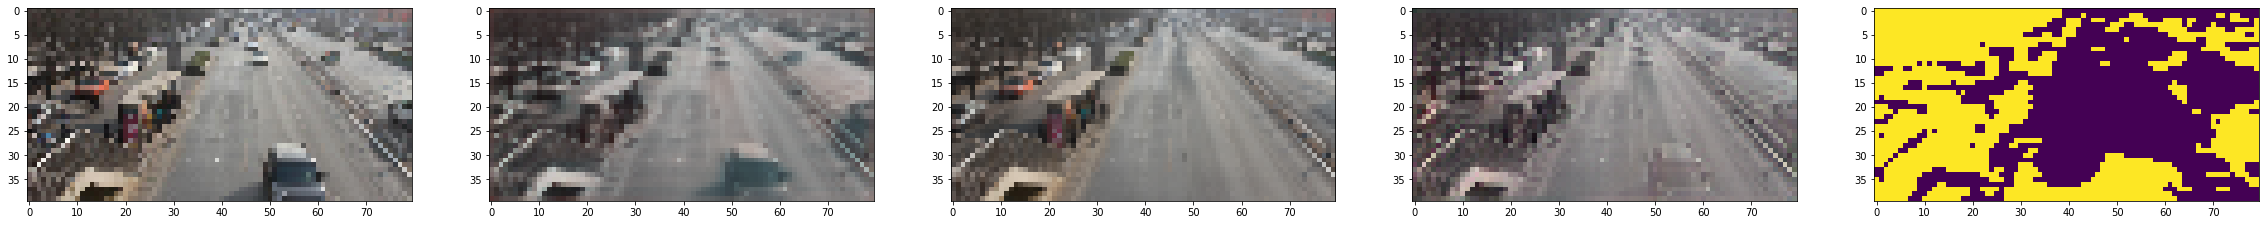

epoch [31/300], loss_total:0.0028, loss_background:0.0010, loss_all:0.0019, time elapsed:22.0656 (sec)
epoch [32/300], loss_total:0.0028, loss_background:0.0010, loss_all:0.0018, time elapsed:19.0471 (sec)
epoch [33/300], loss_total:0.0027, loss_background:0.0009, loss_all:0.0018, time elapsed:18.9678 (sec)
epoch [34/300], loss_total:0.0026, loss_background:0.0009, loss_all:0.0017, time elapsed:19.0376 (sec)
epoch [35/300], loss_total:0.0026, loss_background:0.0009, loss_all:0.0017, time elapsed:19.3275 (sec)


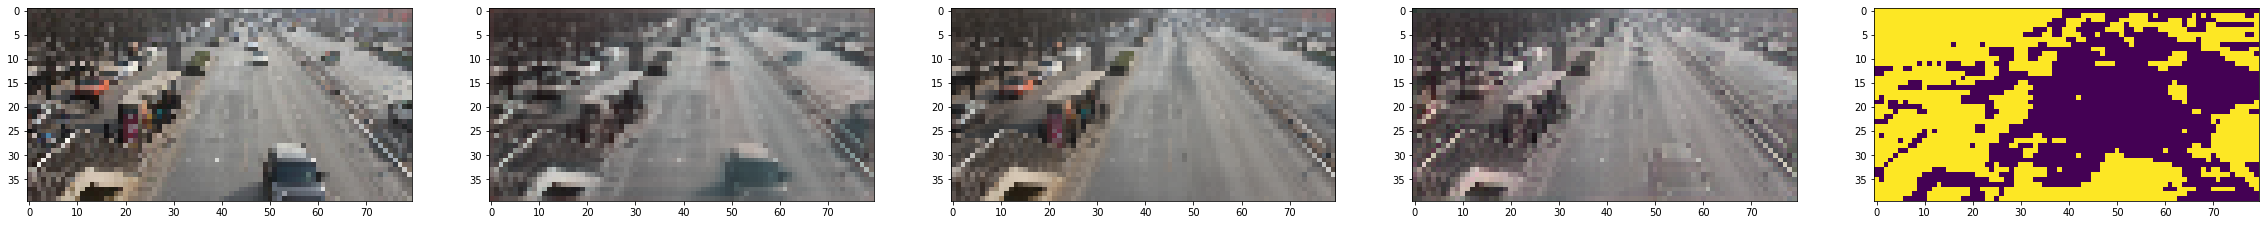

epoch [36/300], loss_total:0.0025, loss_background:0.0008, loss_all:0.0016, time elapsed:21.6318 (sec)
epoch [37/300], loss_total:0.0024, loss_background:0.0009, loss_all:0.0016, time elapsed:19.0643 (sec)
epoch [38/300], loss_total:0.0023, loss_background:0.0008, loss_all:0.0015, time elapsed:19.1123 (sec)
epoch [39/300], loss_total:0.0024, loss_background:0.0009, loss_all:0.0016, time elapsed:19.2665 (sec)
epoch [40/300], loss_total:0.0023, loss_background:0.0008, loss_all:0.0015, time elapsed:19.0312 (sec)


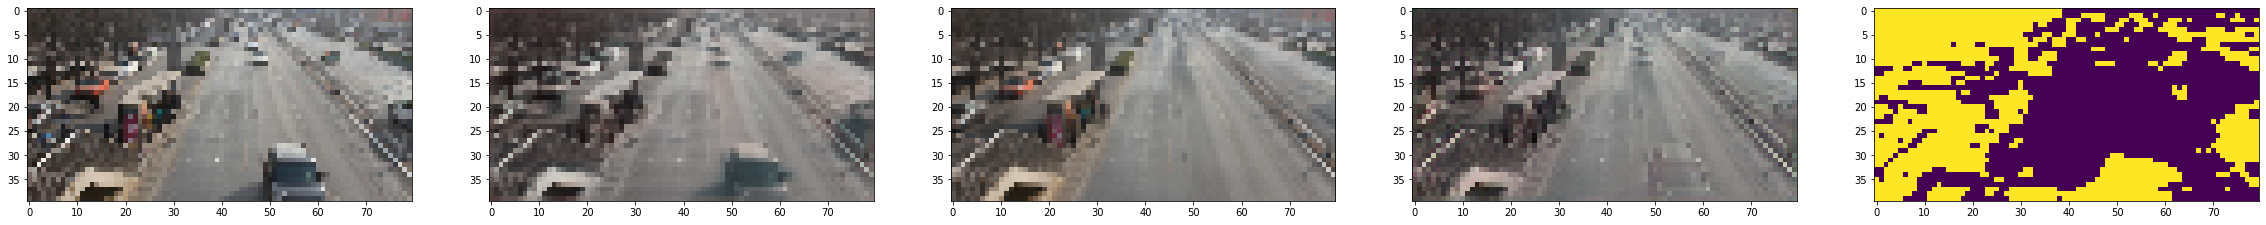

epoch [41/300], loss_total:0.0024, loss_background:0.0009, loss_all:0.0015, time elapsed:22.7078 (sec)
epoch [42/300], loss_total:0.0025, loss_background:0.0009, loss_all:0.0015, time elapsed:19.2166 (sec)
epoch [43/300], loss_total:0.0023, loss_background:0.0009, loss_all:0.0014, time elapsed:19.2452 (sec)
epoch [44/300], loss_total:0.0022, loss_background:0.0008, loss_all:0.0014, time elapsed:19.1625 (sec)
epoch [45/300], loss_total:0.0023, loss_background:0.0008, loss_all:0.0015, time elapsed:19.0238 (sec)


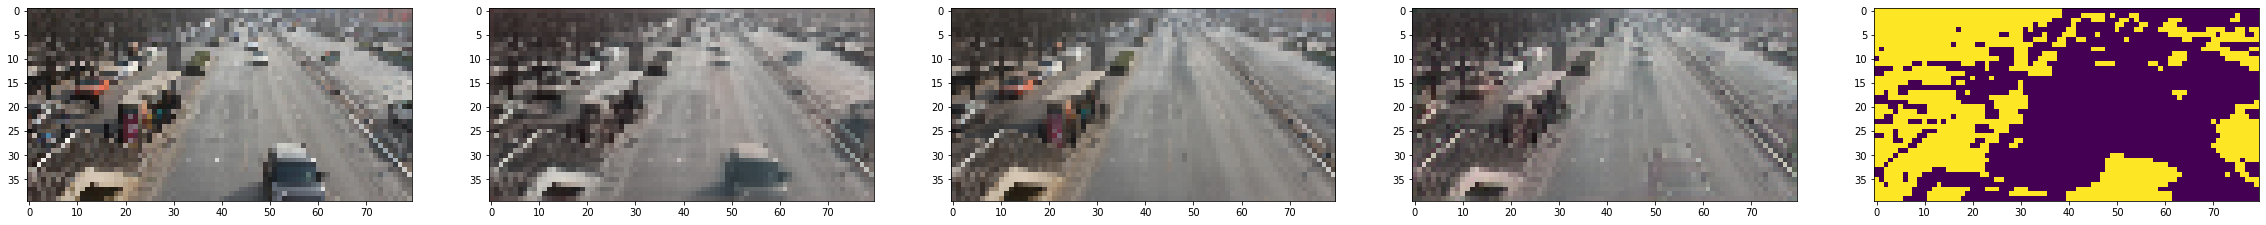

epoch [46/300], loss_total:0.0020, loss_background:0.0007, loss_all:0.0013, time elapsed:21.6804 (sec)
epoch [47/300], loss_total:0.0026, loss_background:0.0011, loss_all:0.0015, time elapsed:19.0308 (sec)
epoch [48/300], loss_total:0.0020, loss_background:0.0007, loss_all:0.0013, time elapsed:19.1354 (sec)
epoch [49/300], loss_total:0.0021, loss_background:0.0008, loss_all:0.0013, time elapsed:19.0407 (sec)
epoch [50/300], loss_total:0.0020, loss_background:0.0007, loss_all:0.0013, time elapsed:19.1710 (sec)


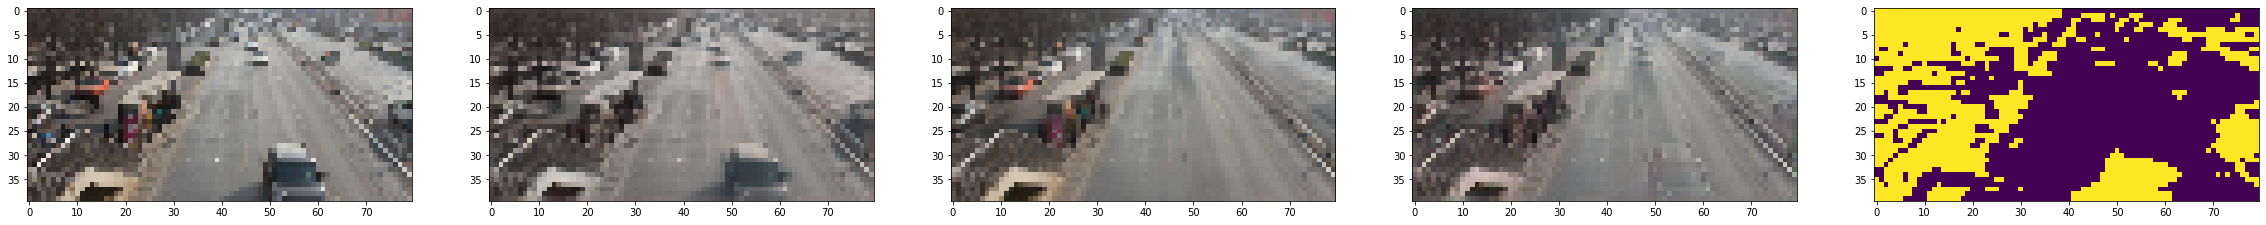

epoch [51/300], loss_total:0.0021, loss_background:0.0008, loss_all:0.0013, time elapsed:21.6949 (sec)
epoch [52/300], loss_total:0.0021, loss_background:0.0008, loss_all:0.0013, time elapsed:19.1076 (sec)
epoch [53/300], loss_total:0.0021, loss_background:0.0007, loss_all:0.0013, time elapsed:19.5420 (sec)
epoch [54/300], loss_total:0.0020, loss_background:0.0007, loss_all:0.0012, time elapsed:18.9846 (sec)
epoch [55/300], loss_total:0.0020, loss_background:0.0007, loss_all:0.0013, time elapsed:18.9681 (sec)


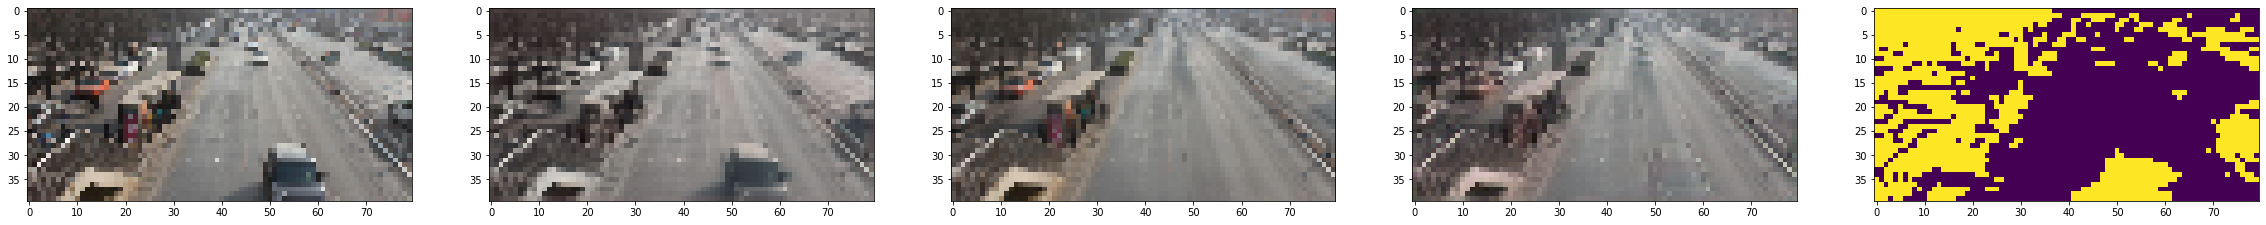

epoch [56/300], loss_total:0.0020, loss_background:0.0007, loss_all:0.0012, time elapsed:21.8877 (sec)
epoch [57/300], loss_total:0.0019, loss_background:0.0007, loss_all:0.0012, time elapsed:19.1536 (sec)
epoch [58/300], loss_total:0.0018, loss_background:0.0007, loss_all:0.0011, time elapsed:19.0455 (sec)
epoch [59/300], loss_total:0.0017, loss_background:0.0006, loss_all:0.0011, time elapsed:19.1729 (sec)
epoch [60/300], loss_total:0.0017, loss_background:0.0006, loss_all:0.0011, time elapsed:19.2903 (sec)


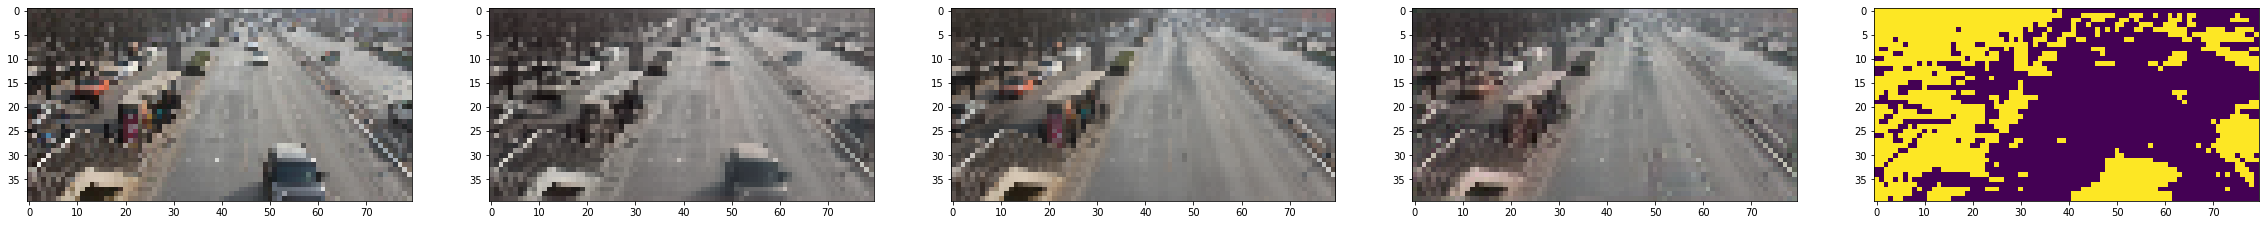

epoch [61/300], loss_total:0.0016, loss_background:0.0006, loss_all:0.0010, time elapsed:21.8051 (sec)
epoch [62/300], loss_total:0.0020, loss_background:0.0007, loss_all:0.0012, time elapsed:19.2055 (sec)
epoch [63/300], loss_total:0.0016, loss_background:0.0006, loss_all:0.0010, time elapsed:18.9284 (sec)
epoch [64/300], loss_total:0.0016, loss_background:0.0006, loss_all:0.0010, time elapsed:19.0792 (sec)
epoch [65/300], loss_total:0.0021, loss_background:0.0009, loss_all:0.0013, time elapsed:19.2045 (sec)


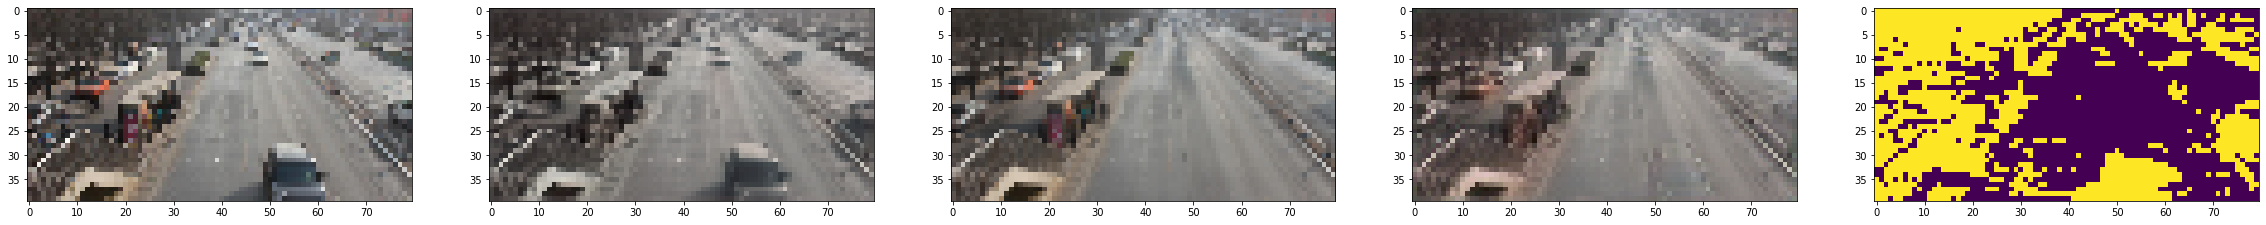

epoch [66/300], loss_total:0.0020, loss_background:0.0009, loss_all:0.0011, time elapsed:21.8621 (sec)
epoch [67/300], loss_total:0.0018, loss_background:0.0008, loss_all:0.0011, time elapsed:19.0662 (sec)
epoch [68/300], loss_total:0.0015, loss_background:0.0006, loss_all:0.0009, time elapsed:18.9760 (sec)
epoch [69/300], loss_total:0.0019, loss_background:0.0008, loss_all:0.0011, time elapsed:19.0726 (sec)
epoch [70/300], loss_total:0.0018, loss_background:0.0007, loss_all:0.0011, time elapsed:19.1065 (sec)


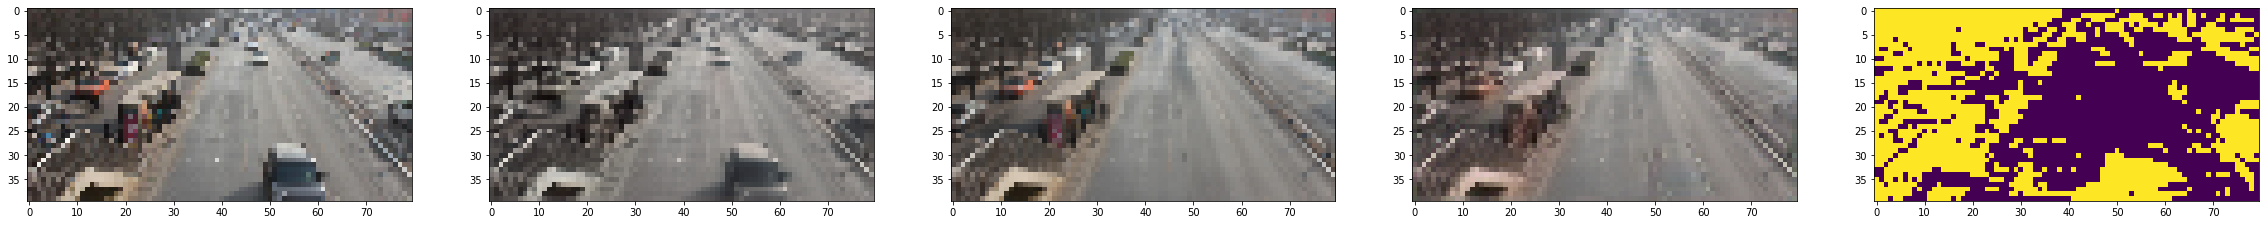

epoch [71/300], loss_total:0.0019, loss_background:0.0008, loss_all:0.0011, time elapsed:21.7604 (sec)
epoch [72/300], loss_total:0.0018, loss_background:0.0007, loss_all:0.0011, time elapsed:19.0657 (sec)
epoch [73/300], loss_total:0.0019, loss_background:0.0008, loss_all:0.0011, time elapsed:18.8396 (sec)
epoch [74/300], loss_total:0.0016, loss_background:0.0007, loss_all:0.0009, time elapsed:19.0680 (sec)
epoch [75/300], loss_total:0.0014, loss_background:0.0006, loss_all:0.0009, time elapsed:18.9675 (sec)


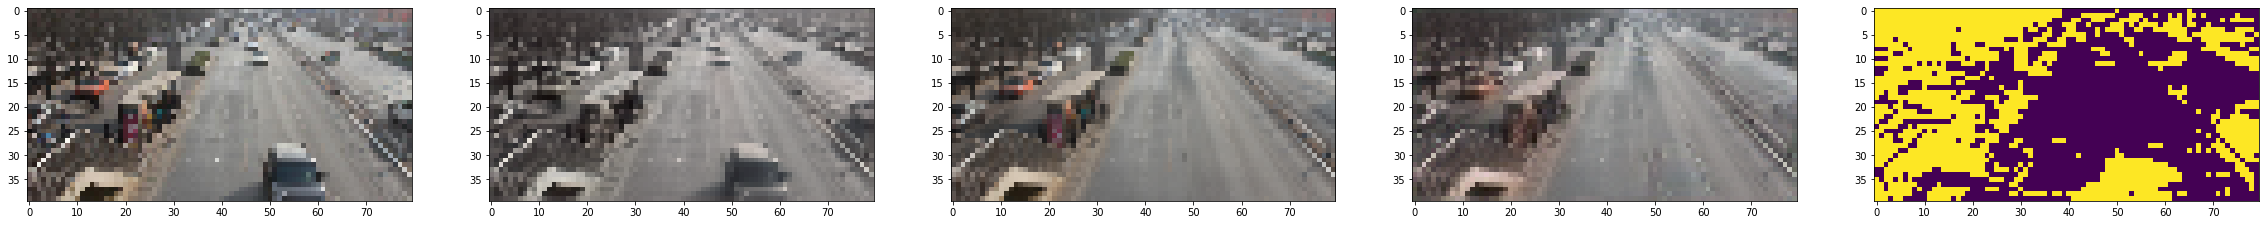

epoch [76/300], loss_total:0.0014, loss_background:0.0005, loss_all:0.0009, time elapsed:21.9764 (sec)
epoch [77/300], loss_total:0.0014, loss_background:0.0005, loss_all:0.0009, time elapsed:19.1854 (sec)
epoch [78/300], loss_total:0.0014, loss_background:0.0005, loss_all:0.0009, time elapsed:19.0611 (sec)
epoch [79/300], loss_total:0.0022, loss_background:0.0010, loss_all:0.0013, time elapsed:19.1420 (sec)
epoch [80/300], loss_total:0.0013, loss_background:0.0005, loss_all:0.0009, time elapsed:19.0970 (sec)


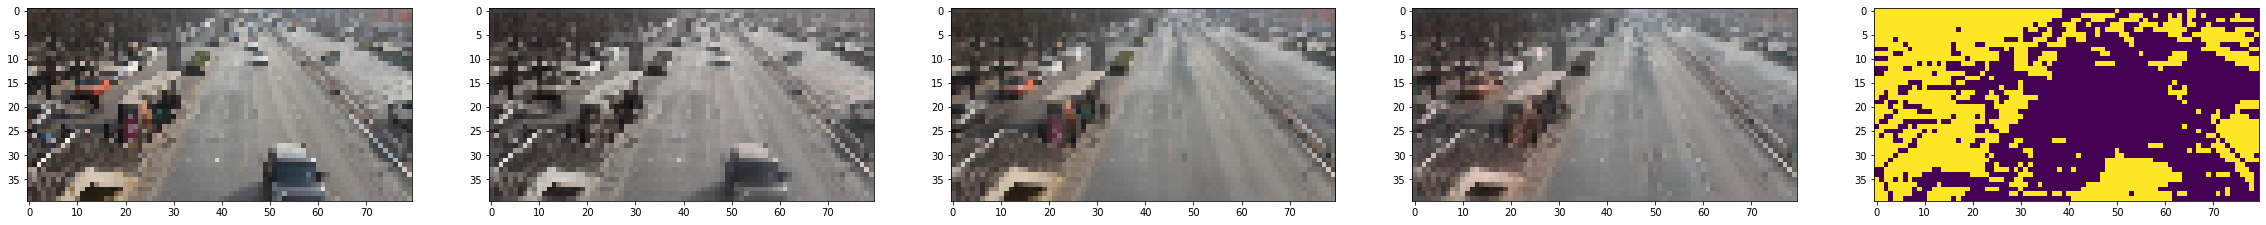

epoch [81/300], loss_total:0.0013, loss_background:0.0005, loss_all:0.0008, time elapsed:21.6977 (sec)
epoch [82/300], loss_total:0.0014, loss_background:0.0005, loss_all:0.0009, time elapsed:19.1087 (sec)
epoch [83/300], loss_total:0.0013, loss_background:0.0005, loss_all:0.0008, time elapsed:19.1043 (sec)
epoch [84/300], loss_total:0.0015, loss_background:0.0006, loss_all:0.0009, time elapsed:19.1313 (sec)
epoch [85/300], loss_total:0.0014, loss_background:0.0005, loss_all:0.0008, time elapsed:19.2318 (sec)


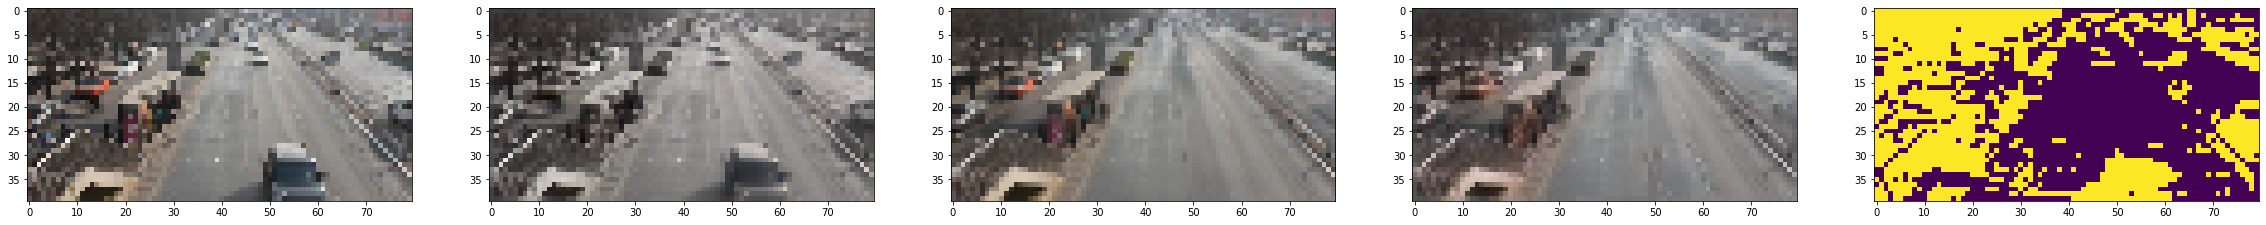

epoch [86/300], loss_total:0.0017, loss_background:0.0008, loss_all:0.0009, time elapsed:21.6936 (sec)
epoch [87/300], loss_total:0.0013, loss_background:0.0005, loss_all:0.0008, time elapsed:19.1098 (sec)
epoch [88/300], loss_total:0.0012, loss_background:0.0004, loss_all:0.0008, time elapsed:19.0755 (sec)
epoch [89/300], loss_total:0.0013, loss_background:0.0005, loss_all:0.0008, time elapsed:19.5139 (sec)
epoch [90/300], loss_total:0.0012, loss_background:0.0004, loss_all:0.0008, time elapsed:19.1254 (sec)


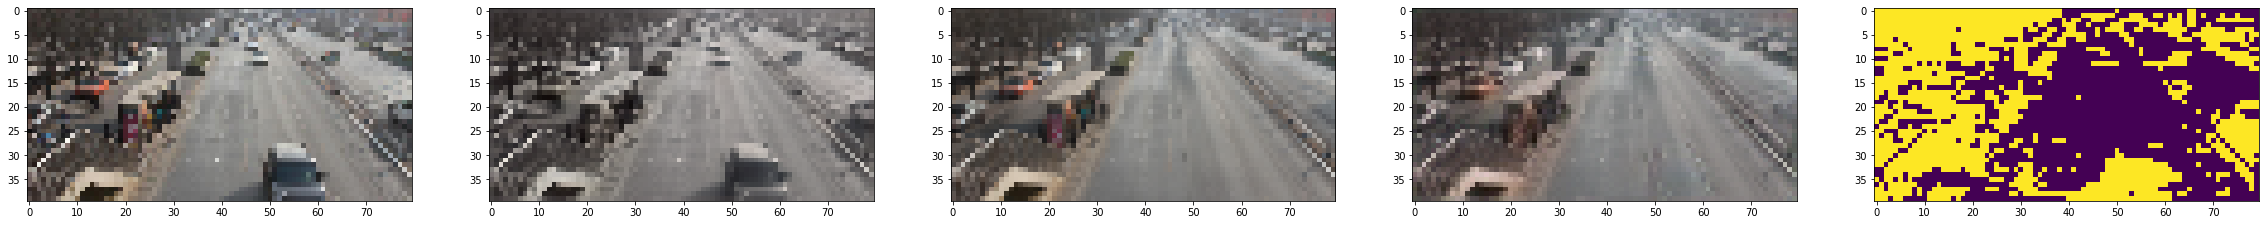

epoch [91/300], loss_total:0.0015, loss_background:0.0006, loss_all:0.0009, time elapsed:21.8213 (sec)
epoch [92/300], loss_total:0.0012, loss_background:0.0005, loss_all:0.0007, time elapsed:19.1902 (sec)
epoch [93/300], loss_total:0.0012, loss_background:0.0005, loss_all:0.0007, time elapsed:19.0770 (sec)
epoch [94/300], loss_total:0.0016, loss_background:0.0007, loss_all:0.0009, time elapsed:19.2676 (sec)
epoch [95/300], loss_total:0.0012, loss_background:0.0004, loss_all:0.0008, time elapsed:19.1027 (sec)


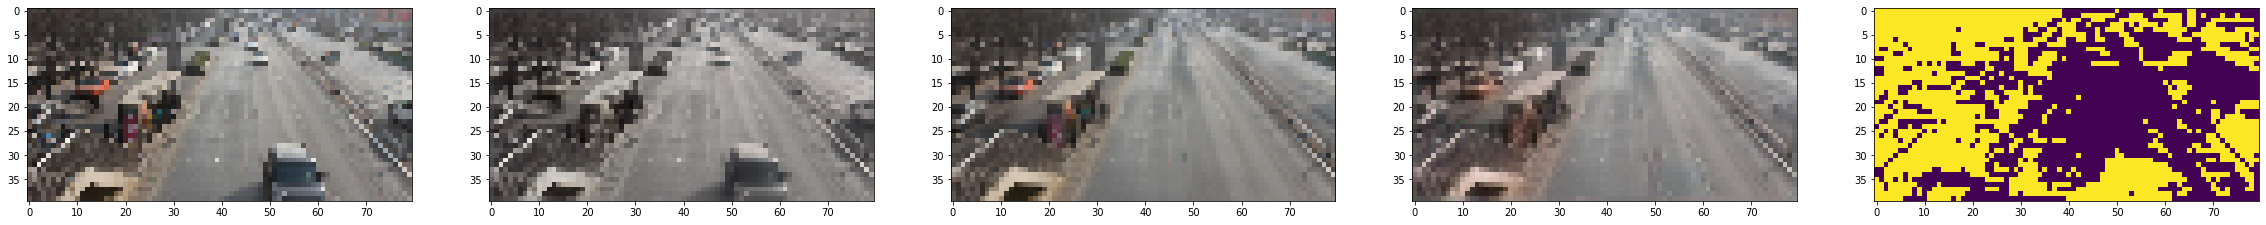

KeyboardInterrupt: 

In [12]:
## Paper training stats
# learning_rate = 0.003
# dropout rate is 0.65
# batch size is 10
# learning rate dropped by 10 every 1000 iteration
# training stopped at 50000 iterations (assuming this is epoch)
learning_rate = 0.0001 # our loop starts by dividing 10
total_epochs = 300
l2_reg = 1e-5


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = l2_reg)
loss_amp_factor = 1
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
for epoch in range(total_epochs):
 #   if epoch % 1000 == 0:
 #       optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
    
    st = time.perf_counter()
    for i, images in enumerate(train_loader):    # Ignore image labels
        images_cuda = images.cuda()
        background_img = torch.mean(images_cuda, dim = 0)
        background_imgs = background_img.unsqueeze_(0)
        background_imgs = background_imgs.expand(batch_size,-1,-1,-1)
        images_input_cuda = torch.cat((images_cuda, background_imgs), dim = 1) #concatenate them as channels..
        compressed, background, foreground, final = model(images_input_cuda)  
        #print_grad("Before zero_grad") ##

        optimizer.zero_grad()
        #print_grad("After zero_grad") ##
        
        
        assert(background_imgs.size() == background.size())
        loss_back = custom_distance_loss(background, background_imgs, loss_amp_factor)
        #loss_back = loss_amp_factor * distance(background, background_imgs)
        loss_back.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        #final = background + foreground
        #final[final > 1] = 1
        #final[final < 0] = 0
        loss_all = distance(final, images_cuda)
        loss_all.backward()
        #print_grad("After 2nd loss backward")
        optimizer.step()
        #print_grad("After 2nd grad application")
        
        # while training, I want to investigate how my images change...so let's write code for that
        if epoch % 5 == 0 and i == 0:
            background_ref_cpu = convert(background_imgs)
            background_cpu = convert(background)
            foreground_cpu = convert_soft(foreground)
            original_cpu = convert(images_cuda)
            final_cpu = convert(final)
            
            
            fig = plt.figure(figsize=(40,80))
            columns = 5
            rows = 1
            for j in range(columns):
                fig.add_subplot(rows,columns,j + 1)
                if j == 0:     
                    plt.imshow(original_cpu[0])
                if j == 1:
                    plt.imshow(final_cpu[0])
                if j == 2:
                    plt.imshow(background_ref_cpu[0])
                if j == 3:
                    plt.imshow(background_cpu[0])
                if j == 4:
                    plt.imshow(foreground_cpu[0])

            plt.show()

    print('epoch [{}/{}], loss_total:{:.4f}, loss_background:{:.4f}, loss_all:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, total_epochs, loss_back.data + loss_all.data, loss_back.data, loss_all.data, time.perf_counter() - st))
    

In [17]:
# We will save the segmented images of the dataset...
import cv2

for i, images in enumerate(train_loader):
    images_cuda = images.cuda()
    background_img = torch.mean(images_cuda, dim = 0)
    background_imgs = background_img.unsqueeze_(0)
    background_imgs = background_imgs.expand(batch_size,-1,-1,-1)
    images_input_cuda = torch.cat((images_cuda, background_imgs), dim = 1)
    compressed, background, foreground, final = model(images_input_cuda)
    n,c,h,w = foreground.size()
    foreground_seged = convert_soft(foreground)
    final_ = convert(final)
    #print(foreground_seged.shape)
    #fig = plt.figure(figsize=(40,80))
    for j in range(n):
        
        cv2.imwrite("seged_images/image{:06d}.jpg".format(i*n+j), foreground_seged[j,:,:]) 
        """
        if j == 0:
            fig.add_subplot(1,2,1)
            plt.imshow(foreground_seged[j,:,:])
            plt.show()
            fig.add_subplot(1,2,2)
            plt.imshow(final_[j,:,:,:])
            plt.show()
        """
        

In [21]:
"image{:06d}".format(10)

'image000010'

## Load the segmented image and try bunch of boxing stuff
1. Try Simple contour detection
2. Try method mentioned in videoPCA
3. Try Softseg


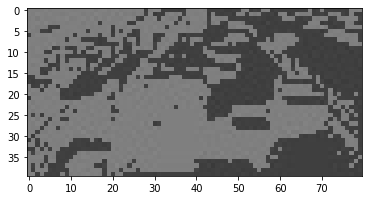

In [18]:
image = cv2.imread('seged_images/image001000.jpg')
plt.imshow(image, cmap = 'gray')
plt.show()

In [19]:
def draw_contours(original_img, img, num):
    import random as rng
    rng.seed(12345)
    import cv2 as cv
    contours, aaaa = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print("No contours in image")
        return
    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])
        centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])

    drawing = np.copy(original_img)
    
    
    print(len(contours))
    for i in range(len(contours)):
        color = (random.randint(0, 255),random.randint(0, 255),random.randint(0, 255))
        #cv.drawContours(drawing, contours_poly, i, color)
        #cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
        #      (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        cv.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)

    plt.subplot(num), plt.imshow(drawing)
    plt.title('Contour Image'), plt.xticks([]), plt.yticks([])
    
    return

In [42]:

curr = os.path.join(os.getcwd(),'seged_images')
seged_images_name = os.listdir('seged_images')

seged_images = np.ndarray((len(seged_images_name),40,80))
seged_images3 = np.ndarray((len(seged_images_name),40,80,3))
for i in range(len(seged_images_name)):
    seged_images[i] = cv2.imread( os.path.join(curr, seged_images_name[i]), 0)
    seged_images3[i] = cv2.imread( os.path.join(curr, seged_images_name[i]), 1)
    


In [40]:
seged_images[seged_images < 255 ] = 0

/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


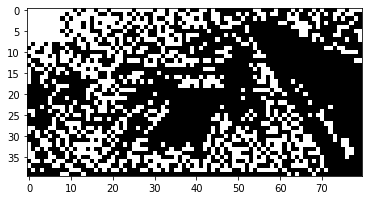

In [47]:
image = np.copy(seged_images[0])
image[image < 127] = 0
image[image >= 127] = 255
plt.imshow(image, cmap='gray')
plt.show()

error: OpenCV(4.1.0) ../modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


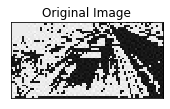

In [43]:
n,h,w = seged_images.shape


for i in range(n):
    plt.subplot(121),plt.imshow(seged_images[i],cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    draw_contours(seged_images3[i,:,:,:], seged_images[i,:,:], 122)
    plt.show()

In [ ]:
### Video Background Subtraction Using Opencv

import numpy as np
import cv2

#fgbg = cv2.bgsegm.createBackgroundSubtractorCNT(minPixelStability=50)
#fgbg = cv2.bgsegm.createBackgroundSubtractorGSOC(mc = cv2.bgsegm.LSBP_CAMERA_MOTION_COMPENSATION_LK, hitsThreshold = 30)
#fgbg.apply(X_mvi_down[0,:,:])
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()

# Training step

st = time.time()
for i in range(200):
    src_gray = cv2.blur(X_mvi_down[i,:,:], (3,3))
    fgmask = fgbg.apply(src_gray)
    
print("Done training, took", time.time() - st, "seconds")
    
for i in range(20):
    src_gray = cv2.blur(X_mvi_down[i,:,:], (7,7))
    fgmask = fgbg.apply(src_gray)
    
    
    edges = cv2.Canny(fgmask, 100, 200)
    plt.subplot(131), plt.imshow(src_gray, cmap = 'gray')
    plt.subplot(132),plt.imshow(fgmask,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    #plt.subplot(143),plt.imshow(edges,cmap = 'gray')
    #plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    draw_contours(X_mvi_down_no[i,:,:], fgmask, 133)
    plt.show()

